In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
from PIL import Image
import gc, math
import pickle

from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from cnnmsemodels import vgg_std16_model, preprocess_input, create_rect5, load_img
from cnnmsemodels import identity_block, conv_block, resnet50_model
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Input
from keras.models import Model
from keras import backend as K
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator


%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# Params
img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_class = 1
ROWS, COLS = 224, 224
BATCHSIZE = 64
SEAL_CLASSES = ['NoS', 'seal']
bins = [0, 1, 1000]
nb_perClass = int(BATCHSIZE / len(bins))
TRAIN_DIR = '../darknet/seals/JPEGImagesBlk'
TEST_DIR = '../darknet/seals/JPEGImagesTest'
FEAT_DIR = "../feat"
# Data generator
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)

In [3]:
def get_model(img_rows, img_cols, channel=1, num_class=1):
    input_shape = (channel, img_rows, img_cols)

    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(channel, img_rows, img_cols)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(1, 3, 3, activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(GlobalAveragePooling2D())
    
    #print (model.summary())
    sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
             
    return model

def train_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, 1), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby(['bins'], as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(TRAIN_DIR, row[0])
            cropped = load_img(image_file+'.jpg',target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y[i] = row[1]
            i += 1
        yield (batch_x.transpose(0, 3, 1, 2), batch_y)
        #return (batch_x.transpose(0, 3, 1, 2), batch_y)
def testcv_generator(df, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(TRAIN_DIR, row[0]+'.jpg')
            cropped = load_img(image_file,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())       
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        yield(batch_x.transpose(0, 3, 1, 2))

In [4]:
# Load up the count per image

coords = pd.read_csv(os.path.join(FEAT_DIR, "block_coords.csv"))
coords = coords[['id', 'block', 'colors']].groupby(['id', 'block']).agg(['count']).reset_index()
coords['img'] = coords['id'].apply(str) + '_' + coords['block'].map("{:02}".format).apply(str) # format(row['block'], '02d')
coords['count'] = coords['colors']
coords['bins'] = pd.cut(coords['count'], bins=bins)
coords = coords[['img', 'count', 'bins']]

#coords.columns = ['img', 'count', 'bins']
coords.head(2)

,img,count,bins
,,,
0,0_03,1,"(0, 1]"
1,0_04,8,"(1, 1000]"


In [5]:
# Lets make our validation set
folds = [coords.img.str.split('_').apply(lambda x: x[0]).astype(int) % 2 != 0,
        coords.img.str.split('_').apply(lambda x: x[0]).astype(int) % 2 == 0]

In [6]:
for fold in range(1, 2):
    print "Fold: " + str(fold+1)
    train_df = coords[~folds[fold]]
    test_df = coords[folds[fold]]
    valid_df = test_df
    # Set up validation data
    df_1 = valid_df
    l = valid_df.groupby('bins').size()
    valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
    valid_y = np.zeros((valid_df.shape[0], 1), dtype=K.floatx())
    i = 0
    for index,row in valid_df.iterrows():
        row = row.tolist()
        image_file = os.path.join(TRAIN_DIR, row[0])
        cropped = load_img(image_file+'.jpg',target_size=(ROWS,COLS))
        x = np.asarray(cropped, dtype=K.floatx())
        x = preprocess_input(x)
        valid_x[i] = x
        valid_y[i] = row[1]
        i += 1
    valid_x = valid_x.transpose(0, 3, 1, 2)
    # Load our model
    nb_epoch = 1
    samples_per_epoch = 64*80
    model = get_model(ROWS, COLS, channel, num_class)
    # Start learning
    preds = []
    model.optimizer.lr = 5e-6
    for i in range(15): 
        model.fit_generator(train_generator(train_datagen, train_df),
                  nb_epoch=nb_epoch,
                  samples_per_epoch=samples_per_epoch, #50000,
                  verbose=1,
                  validation_data=(valid_x, valid_y),
                  )
        if i > 11:
            predstmp = model.predict_generator(testcv_generator(test_df), val_samples=test_df.shape[0])
            preds.append(predstmp)
        # Test
    test_preds = sum(preds)/len(preds)
    df = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(test_preds,  columns=['predCount'])], axis=1)
    df.columns = ['img', 'count', 'bins', 'predCount']
    df[['img', 'predCount']].to_csv('../coords/vggcountCVPreds2604_fold' + str(fold+1) + '.csv', index=False)
    ### Clean up
    # del model, train_df, test_df, valid_df, valid_x, df_1
    gc.collect()
    gc.collect()

Fold: 2
Epoch 1/1
5120/5120 [==============================] - 332s - loss: 194.6234 - val_loss: 409.3521
Epoch 1/1
5120/5120 [==============================] - 328s - loss: 196.4198 - val_loss: 409.3519
Epoch 1/1
5120/5120 [==============================] - 332s - loss: 202.3365 - val_loss: 409.3513
Epoch 1/1
5120/5120 [==============================] - 329s - loss: 205.8670 - val_loss: 369.9639
Epoch 1/1
5120/5120 [==============================] - 337s - loss: 150.4492 - val_loss: 308.0206
Epoch 1/1
5120/5120 [==============================] - 337s - loss: 155.9636 - val_loss: 293.8772
Epoch 1/1
5120/5120 [==============================] - 336s - loss: 138.8840 - val_loss: 260.0814
Epoch 1/1
5120/5120 [==============================] - 338s - loss: 115.1754 - val_loss: 304.6801
Epoch 1/1
5120/5120 [==============================] - 334s - loss: 112.4992 - val_loss: 235.0467
Epoch 1/1
5120/5120 [==============================] - 337s - loss: 104.4110 - val_loss: 249.3565
Epoch 1/1
51

0

12.7019645259
17.1799442639


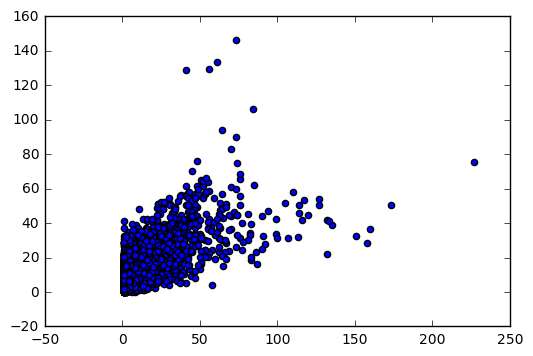

In [7]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
#test_df = coords[folds[fold]]
y_true = df['count'].tolist()
y_pred = df['predCount'].tolist()
print(mean_squared_error(y_true, y_pred)**0.5)
print(mean_squared_error(y_true, [np.mean(y_true)]*len(y_true))**0.5)
plt.scatter(y_true, y_pred)
plt.show()

In [8]:
range(1,2)

[1]